In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import *

import io, requests, glob

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from starfish import data
import pprint
import seaborn as sns

# import plotly.express as px
# import plotly.io as pio
# pio.renderers.default='notebook'

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [661]:
bench_df = get_mop_benchmark()
code_ref, targets = get_mop_codebook()

17130008


In [662]:
# max_p_150 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]
# max_p_151 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images151.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]
# max_p_47 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]

In [664]:
# fids_150 = get_peaks(max_p_150, 18000, 20)
# fids_151 = get_peaks(max_p_151, 18000, 20)
# fids_47 = get_peaks(max_p_47, 18000, 20)

In [683]:
select = ['base']#,'bs:20xcrop_sz:56xbl_loss_scale:0.003','crop_sz:56','bs:15','bs:20']

sweep_name = 'sweep_mop_21'
file_nrs = [150,151,47]

out_dir = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/{sweep_name}/*'
files = glob.glob(out_dir)
base_str = 'bsub -gpu "num=1" -q gpu_rtx -n 3 -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_eval.py '

with open('run_slurm.sh', 'w') as f:
    for nr in file_nrs:
        for n in files:
            if 'mean_diff' not in n and 'test' not in n:
                name = n.split('/')[-1]
                if 'step' not in name:
                    print(name)
                    f.write(base_str + f'run_name={name} sweep_name={sweep_name} file_nr={nr} \n')
#                     print(base_str + f'run_name={name} sweep_name={sweep_name} file_nr={nr} \n')

schedule:nullxfreq:1xnorm:none
schedule:nullxfreq:3xnorm:escort
norm:nonexz_facs:True
norm:escortxz_facs:True
schedule:nullxfreq:1xnorm:escort
norm:escortxz_sig_fac:1.0
norm:nonexz_sig_fac:1.0
schedule:nullxfreq:3xnorm:none
schedule:nullxfreq:1xnorm:none
schedule:nullxfreq:3xnorm:escort
norm:nonexz_facs:True
norm:escortxz_facs:True
schedule:nullxfreq:1xnorm:escort
norm:escortxz_sig_fac:1.0
norm:nonexz_sig_fac:1.0
schedule:nullxfreq:3xnorm:none
schedule:nullxfreq:1xnorm:none
schedule:nullxfreq:3xnorm:escort
norm:nonexz_facs:True
norm:escortxz_facs:True
schedule:nullxfreq:1xnorm:escort
norm:escortxz_sig_fac:1.0
norm:nonexz_sig_fac:1.0
schedule:nullxfreq:3xnorm:none


In [667]:
def clean_bench_df(bench_df, fids=None):
    bench_df = nm_to_px((bench_df), [1.085,1.085,1.085])
    bench_df['x'] += 70
    bench_df['y'] += 70
    bench_df = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
#     bench_df = remove_fids(bench_df, px_to_nm(fids), tolerance=1000)
    bench_df = remove_doublets(bench_df, tolerance=200)
    return bench_df

def clean_istd_df(bench_df, fids=None):
    bench_df['loc_idx'] = np.arange(len(bench_df))
    bench_df['gene'] = targets[bench_df['code_inds']]
    bench_df = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
#     bench_df = remove_fids(bench_df, px_to_nm(fids), tolerance=1000)
    bench_df = remove_doublets(bench_df, tolerance=200)
    return bench_df

def log_reg(df, weights={}):
    
    df['score'] = 0
    for k in weights:
        df['score'] += weights[k] * df[k]
    df['score'] = 1/(1 + np.exp(-df['score']))
    return df

In [ ]:
istd_151 = pd.read_csv('../data/results/MERFISH/istdeco_MOp_151.csv')

In [7]:
istd_151 = clean_istd_df(istd_151, fids_47)

NameError: name 'clean_istd_df' is not defined

In [668]:
# bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True, z_to_batch=True)
bench_150 = clean_bench_df(get_mop_fov(bench_df, 150), None)
bench_151 = clean_bench_df(get_mop_fov(bench_df, 151), None)
bench_47 = clean_bench_df(get_mop_fov(bench_df, 47), None)

In [763]:
logr_coefs = {'x_sig': 0.03, 'y_sig': 0.03, 'z_sig': 0.035, 'prob': -2.3}
# logr_coefs = {'x_sig': 0.037, 'z_sig': 0.037, 'prob': -2.3}

In [769]:
df_dict = {'150':{},'151':{},'47':{}}

sweep_name = 'merfish_sweep_mop_21'

for f in glob.glob(f'../data/results/MERFISH/{sweep_name}_*'):
    if '' in f:
        dec_df = pd.read_csv(f)
        print(f, len(dec_df))
        if len(dec_df):

            if '_47' in f:
                ds = '47'
            if '_150' in f:
                ds = '150'
            if '_151' in f:
                ds = '151'

#             dec_df = remove_doublets(dec_df, tolerance=200)
            dec_df = log_reg(dec_df[dec_df['z'] > -0.1], logr_coefs)
            df_dict[ds][f.split(sweep_name)[-1].split('.csv')[0].split('_None')[0]] = dec_df

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:3xnorm:none_None_150.csv 48282


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:escortxz_sig_fac:1.0_None_150.csv 52567


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:nonexz_sig_fac:1.0_None_47.csv 107470


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:1xnorm:escort_None_151.csv 58291


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:1xnorm:escort_None_47.csv 98883


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:1xnorm:none_None_151.csv 57044


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:3xnorm:none_None_151.csv 57848


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:escortxz_facs:True_None_150.csv 49507


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:3xnorm:none_None_47.csv 97161


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:1xnorm:none_None_150.csv 47280


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:escortxz_sig_fac:1.0_None_47.csv 108892


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:escortxz_sig_fac:1.0_None_151.csv 65977


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:nonexz_sig_fac:1.0_None_151.csv 67896


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:1xnorm:escort_None_150.csv 46644


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:1xnorm:none_None_47.csv 97759


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:escortxz_facs:True_None_151.csv 62412


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:3xnorm:escort_None_151.csv 56761


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:nonexz_facs:True_None_150.csv 48275


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:nonexz_facs:True_None_151.csv 59674


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:nonexz_facs:True_None_47.csv 102308


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:escortxz_facs:True_None_47.csv 106839


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:3xnorm:escort_None_47.csv 94896


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_schedule:nullxfreq:3xnorm:escort_None_150.csv 44644


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

../data/results/MERFISH/merfish_sweep_mop_21_norm:nonexz_sig_fac:1.0_None_150.csv 55071


/tmp/ipykernel_34414/23251225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = 0
/tmp/ipykernel_34414/23251225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] += weights[k] * df[k]
/tmp/ipykernel_34414/23251225.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [770]:
names = [k for k in df_dict['151'].keys()]
# del(names[2])
omega_df = DF(columns=pd.MultiIndex.from_product([['150','151','47'], names+['bench']]), index=['N','N_blanks', 'NN_blanks', 'int_sig'])
for d, bm in zip(['150','151','47'], [bench_150,bench_151,bench_47]):
    omega_df.loc['N', d]['bench'] = len(bm)
    omega_df.loc['N_blanks', d]['bench'] = sum(bm['gene'].str.contains('Blank'))
    omega_df.loc['NN_blanks', d]['bench'] = 1.

for n in ['150','151','47']:
    for j in names:
#         if j+f'_{n}' in df_dict[n]:
        if j in df_dict[n]:
            exp_df = df_dict[n][j]
            omega_df.loc['N', n][j] = len(exp_df)
            omega_df.loc['N_blanks', n][j] = sum(exp_df['gene'].str.contains('Blank'))
            if len(exp_df) > omega_df.loc['N', n]['bench']:
                omega_df.loc['NN_blanks', n][j] = sum(exp_df.nsmallest(omega_df.loc['N', n]['bench'], 'score')['gene'].str.contains('Blank'))/omega_df.loc['N_blanks', n]['bench']
            else:
                omega_df.loc['NN_blanks', n][j] = None
            int_arr = sel_int_ch(exp_df.nsmallest(omega_df.loc['N', n]['bench'],'score'), code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values
            ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
            omega_df.loc['int_sig', n][j] = np.sqrt(np.var(ch_means))
#             print(f'{j} not in {n}')

In [771]:
bla = omega_df.mean(level=1, axis=1).loc['NN_blanks']

/tmp/ipykernel_34414/3451002884.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  bla = omega_df.mean(level=1, axis=1).loc['NN_blanks']


<AxesSubplot:>

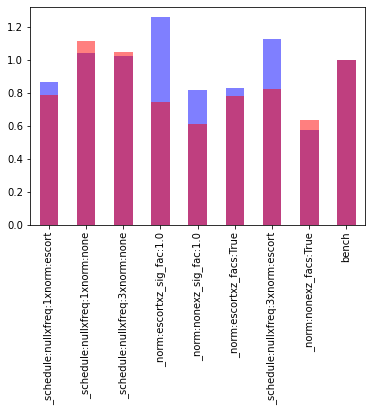

In [772]:
tra.plot.bar(alpha =0.5, color='blue')
bla.plot.bar(alpha =0.5, color='red')

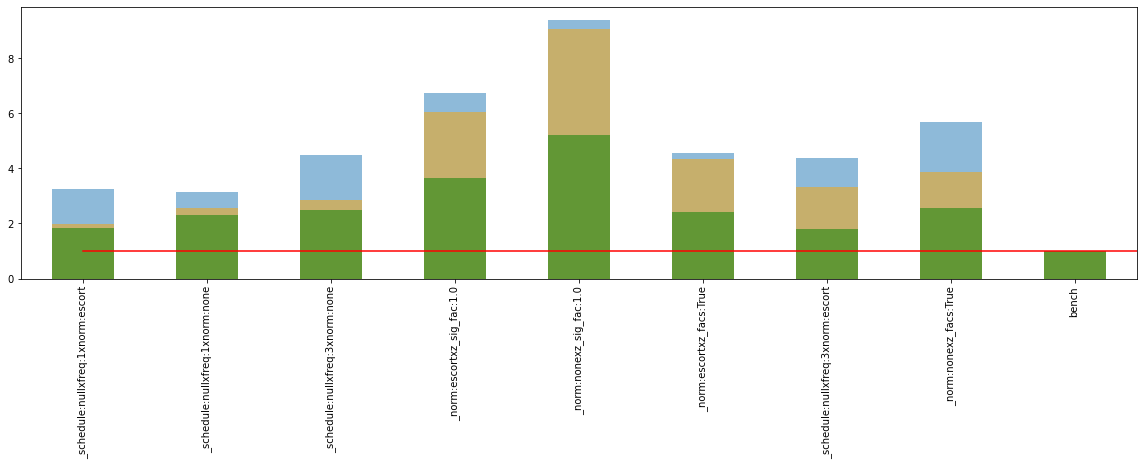

In [749]:
plt.figure(figsize=(20,5))

omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

/tmp/ipykernel_34414/204141080.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')


<AxesSubplot:>

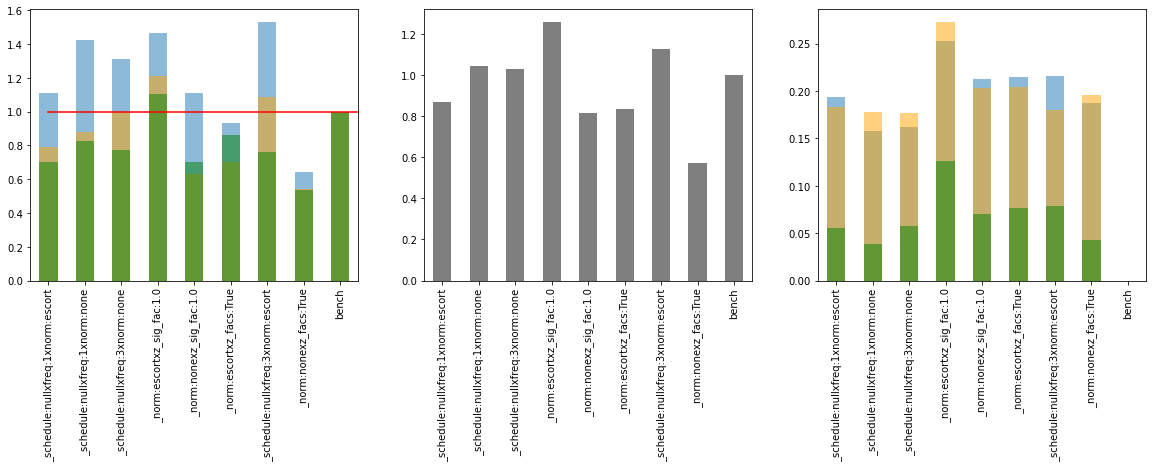

In [699]:
plt.figure(figsize=(20,5))
plt.subplot(131)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.subplot(132)
omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')
plt.subplot(133)
omega_df.loc['int_sig','150'].plot.bar(alpha =0.5)
omega_df.loc['int_sig','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['int_sig','47'].plot.bar(alpha =0.5, color='green')

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



<AxesSubplot:>

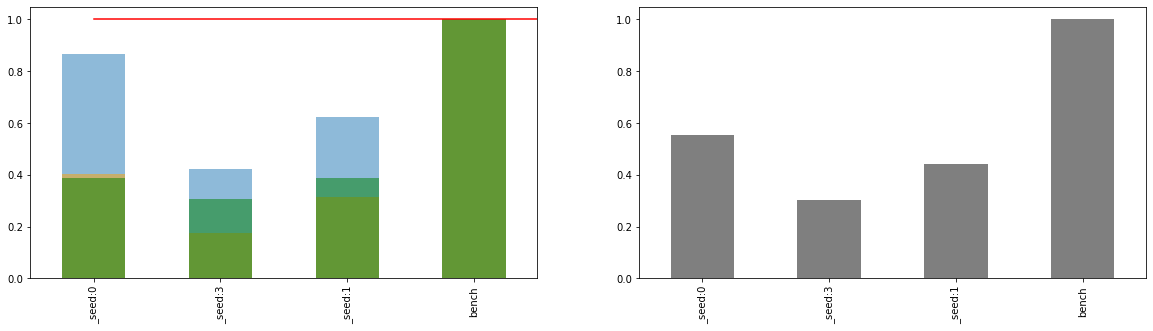

In [846]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.subplot(122)
omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')

In [651]:
res_df = df_dict['47']['_schedule:nullxfreq:3xnorm:escortxz_facs:Truexmean_diff:False']

In [652]:
len(res_df)

56525

In [653]:
_,matches,shift = matching(bench_47, res_df.nsmallest(65000, 'score'), tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.543
Precision: 0.615
Jaccard: 40.527
RMSE_vol: 96.593
Eff_3d: 23.386
FN: 29206.0 FP: 21781.0
Num. matches: 34744.000
Shift: 53.17,17.24,-50.65


In [851]:
_,matches,shift = matching(istd_151.nlargest(50000, 'quality'), res_df.nsmallest(50000, 'score'), tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.002
Precision: 0.002
Jaccard: 0.109
RMSE_vol: 352.061
Eff_3d: -102.398
FN: 49891.0 FP: 49891.0
Num. matches: 109.000
Shift: -1.41,-14.39,1.20


In [1150]:
_,matches,shift = matching(res_df, res_df2, tolerance=300, print_res=True, allow_multiple_matches=False)

Recall: 0.740
Precision: 0.855
Jaccard: 65.702
RMSE_vol: 35.131
Eff_3d: 61.466
FN: 30852.0 FP: 14923.0
Num. matches: 87688.000
Shift: -0.22,-0.05,-0.21


63950 64000


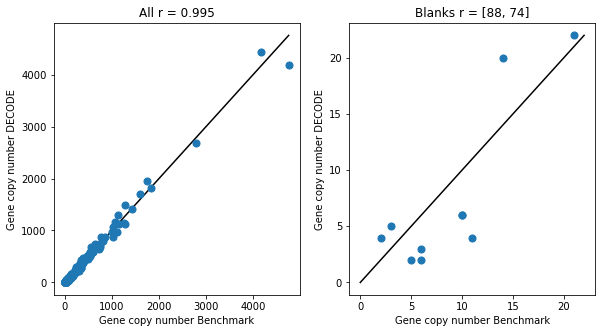

In [634]:
plot_gene_panels(res_df1.nsmallest(64000, 'comb_sig'), bench_47, targets)

63950 64000


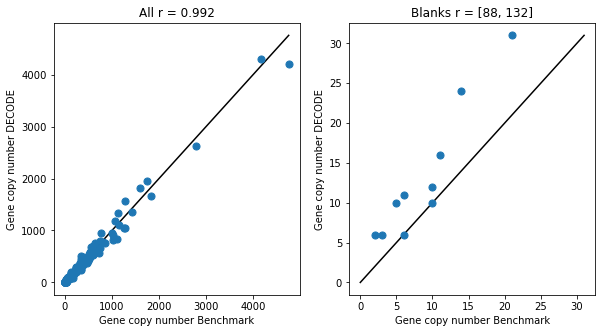

In [635]:
plot_gene_panels(res_df2.nsmallest(64000, 'comb_sig'), bench_47, targets)

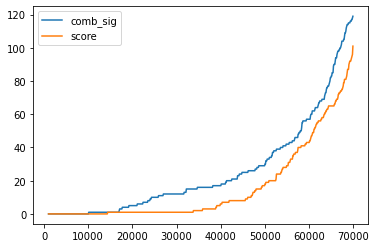

In [622]:
def make_roc(df, var='code_err', ascending=True, n_max=50000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['gene'].str.contains('Blank')).sum())
        
    return x, n_blanks

for k in ['comb_sig','score']:
    r  = make_roc(res_df, k, n_max=70000, ascending=True)
    plt.plot(r[0],r[1], label=k)
plt.legend()

36464 36500


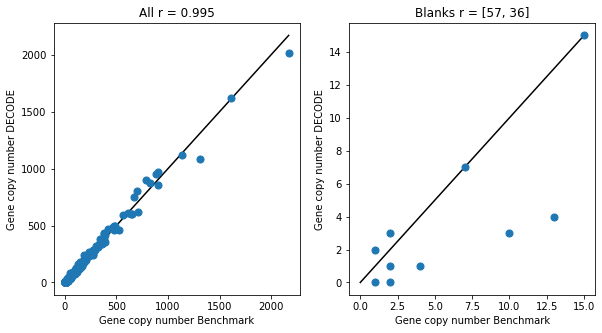

In [497]:
plot_gene_panels(istd_151.nlargest(36500, 'quality'), bench_151, targets)

In [503]:
len(targets)

252

In [997]:
fns = res_df2.loc[~res_df2['loc_idx'].isin(matches['loc_idx_tar'])]
tps = res_df2.loc[res_df2['loc_idx'].isin(matches['loc_idx_tar'])]
fps = res_df.loc[~res_df['loc_idx'].isin(matches['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.233849751534639
0.3033268101761253
0.22388059701492538


In [1030]:
fns = istd_151.loc[~istd_151['loc_idx'].isin(matches['loc_idx_tar'])]
tps = istd_151.loc[istd_151['loc_idx'].isin(matches['loc_idx_tar'])]
fps = res_df.loc[~res_df['loc_idx'].isin(matches['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.11387163561076605
2.4536775421586414
1.5951352780470611


In [705]:
gene_counts = DF(data=None, index=targets)
gene_counts['dec'] = res_sub_s.groupby('gene')['gene'].count()
gene_counts['ist'] = bench_df.groupby('gene')['gene'].count()
gene_counts['tps'] = tps.groupby('gene')['gene'].count()
gene_counts['fps'] = fps.groupby('gene')['gene'].count()
gene_counts['fns'] = fns.groupby('gene')['gene'].count()
gene_counts = gene_counts.fillna(0)

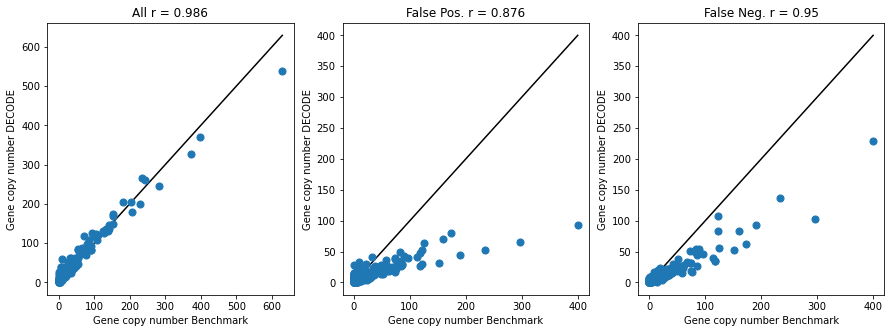

In [706]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plot_gene_numbers(gene_counts['ist'].values, gene_counts['dec'].values, 'All', log=False)
plt.subplot(132)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fps'].values, 'False Pos.', log=False)
plt.subplot(133)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fns'].values, 'False Neg.', log=False)

Text(0.5, 1.0, 'Corr. 0.954')

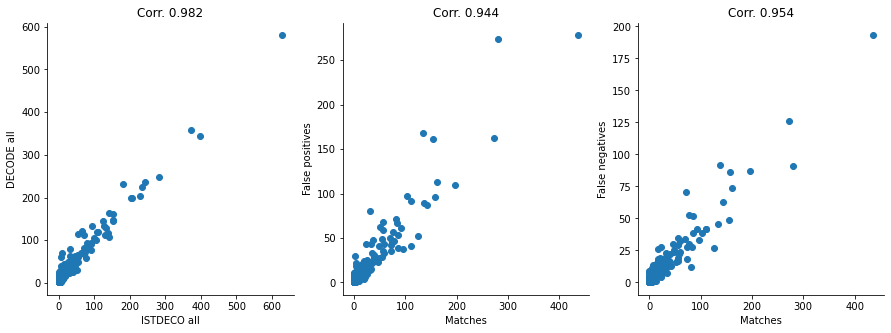

In [676]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(gene_counts['ist'].values, gene_counts['dec'].values)
plt.plot([0,0],[len(gene_counts['ist'].values),len(gene_counts['dec'].values)])
sns.despine()
plt.xlabel('ISTDECO all')
plt.ylabel('DECODE all')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['ist'].values, gene_counts['dec'].values)[0,1])[:5])
plt.subplot(132)
plt.scatter(gene_counts['tps'].values, gene_counts['fps'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False positives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fps'].values)[0,1])[:5])
plt.subplot(133)
plt.scatter(gene_counts['tps'].values, gene_counts['fns'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False negatives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fns'].values)[0,1])[:5])


In [828]:
par_dict = {}
par_dict['istdeco'] = [istd_151, 'quality', False]
for i,k in enumerate(df_dict['151']):
#     if 'dec_' in k and '151' in k:
    if len(df_dict['151'][k]) > 0:
        par_dict[k] = [df_dict['151'][k], 'score', True]
    #         par_dict[k+'_s'] = [remove_doublets(df_dict[k].nsmallest(50000,'comb_sig')), 'comb_sig', True]

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=80000)
    roc_dict[k] = [x, y]

In [998]:
par_dict = {}
par_dict['istdeco'] = [istd_151, 'quality', False]
par_dict['1'] = [res_df1, 'prob', False]
par_dict['2'] = [res_df2, 'prob', False]

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=80000)
    roc_dict[k] = [x, y]

In [999]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict[df.keys()[0]][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [1000]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,150], range_x=[0,80000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

KeyError: 'dec_lr:0.000125xstep_size:1000_None_151'

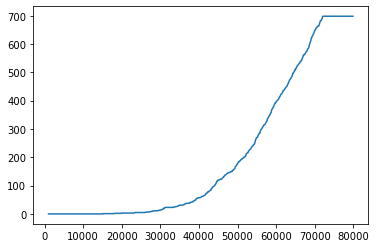

In [831]:
plt.plot(df['x'], df['istdeco'], label='istdeco')
plt.plot(df['x'], df['dec_lr:0.000125xstep_size:1000_None_151'], label='DECODE')
plt.plot([0,45000], [57,57], label='Reference')
plt.plot([36500,36500], [0,100], color='green')
plt.xlim(0,45000)
plt.ylim(0,100)
plt.xlabel('Number transcripts')
plt.xlabel('Number blanks')
plt.legend()

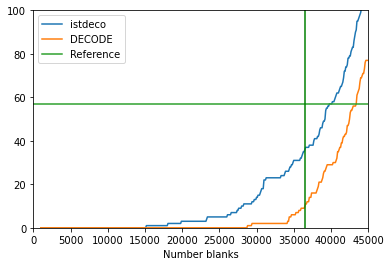

In [722]:
plt.plot(df['x'], df['istdeco'], label='istdeco')
plt.plot(df['x'], df['_seed:3'], label='DECODE')
plt.plot([0,45000], [57,57], label='Reference')qq
plt.plot([36500,36500], [0,100], color='green')
plt.xlim(0,45000)
plt.ylim(0,100)
plt.xlabel('Number transcripts')
plt.xlabel('Number blanks')
plt.legend()

In [569]:
res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2']
int_m = [f'int_{i}' for i in range(4)]
int_s = [f'int_sig_{i}' for i in range(4)]
res_df['int_tot'] = res_df.loc[:,int_m].values.sum(-1)
res_df['int_sig_tot'] = res_df.loc[:,int_s].values.sum(-1)


metrics = ['comb_sig','int_tot','int_sig_tot', 'prob','zm']
bins = [np.linspace(0,1.5,31), np.linspace(0,50,31), np.linspace(0,20,31), np.linspace(0.4,1,31), np.linspace(0,100.,31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

KeyError: 'dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'

In [299]:
res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'].nsmallest(10000, 'comb_sig')

In [290]:
code_cols = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0.,1.,140)]

In [291]:
import mpld3
from mpld3 import plugins

In [663]:
res_sub = df_dict['dec_psf_noise:0.0xrate_fac:3.0'].nsmallest(17000, 'comb_sig')
# res_sub = df_dict['dec_min_int_sig:0.0xint_fac:0.1'].nsmallest(15000, 'code_err')
ist_sub = istdeco_df.nlargest(15000, 'quality')
bench_sub = bench_df.nlargest(13800, 'total_magnitude')

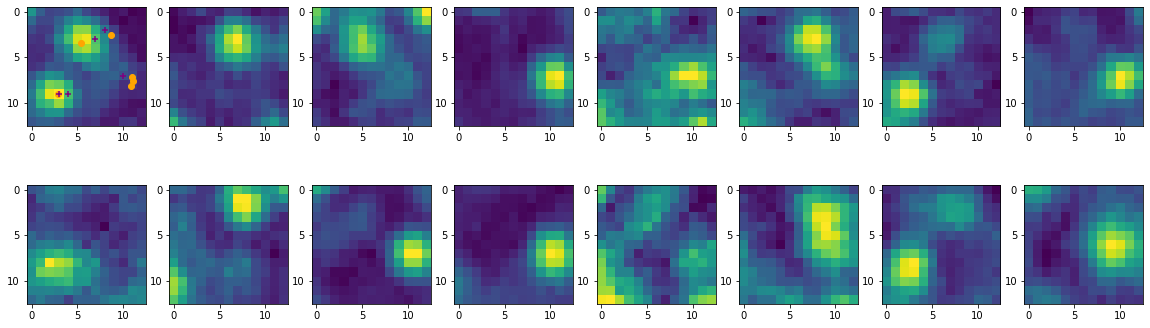

In [664]:
vol, crop = extract_roi(img_stack[None], torch.IntTensor([514,740,0]), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
ist_crop = crop_df(nm_to_px(ist_sub), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(ist_crop['x'],ist_crop['y'],color='purple', marker='+')

In [80]:
img_stack = read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif')[:,:,:,:,:]

In [81]:
img_stack.shape

torch.Size([1, 22, 7, 2048, 2048])

In [82]:
from decode_fish.funcs.dataset import GaussianSmoothing
filt = GaussianSmoothing(11, device='cpu')
img_filt = filt(img_stack)
img_stack -= img_filt

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [83]:
df_dict['47'].keys()

dict_keys(['_phasing:0.2', '_phasing:0.1', '_phasing:0.05', '_phasing:0.0'])

In [249]:
res_df = df_dict['47']['_phasing:0.0'].nsmallest(40000, 'score')
ints = res_df[[f'int_{i}' for i in range(22)]].values
ints[code_ref[res_df['code_inds'].values]==0] = 0.

In [191]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,z, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

In [392]:
z_vols = [[] for _ in range(20)]

In [393]:
int_keys = [f'int_{i}' for i in range(22)]

In [394]:
for i in tqdm(range(len(res_df))):
    b_loc = nm_to_px(res_df.iloc[i])
    vol, crop = extract_roi(img_stack[0], torch.IntTensor(np.array(b_loc.loc[['x','y','frame_idx']].values, dtype='float32')), 6)
    if vol.shape == torch.Size([22, 13, 13]):
        ints = b_loc[int_keys].values.astype('float32')
        volm = vol/ints[:,None,None]
        volm = cpu(volm[code_ref[b_loc['code_inds']].nonzero()[0]])
        z = np.clip(b_loc['z'],0,100)
        z_vols[int(b_loc['zm']/5)].append(volm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [02:11<00:00, 303.68it/s]


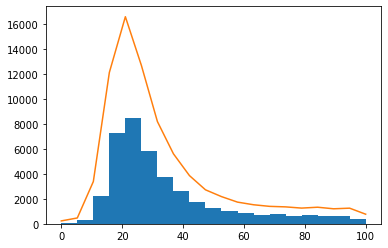

In [360]:
plt.hist(res_df['z'], bins=np.linspace(0,100,20))
plt.plot(np.linspace(0,100,20), [len(z) for z in z_vols])

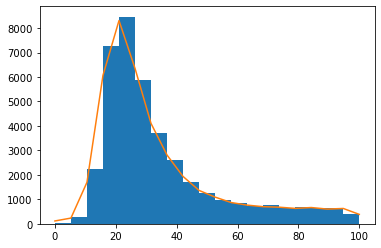

In [363]:
plt.hist(res_df['z'], bins=np.linspace(0,100,20))
plt.plot(np.linspace(0,100,20), [len(z) for z in z_volspn])

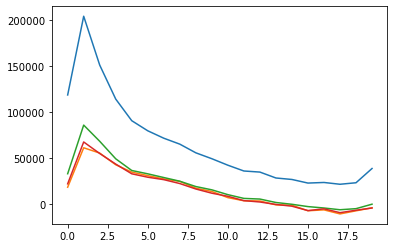

In [398]:
# plt.plot(psf_vol.sum(-1).sum(-1))
plt.plot(get_psf_vol(z_vols).sum(-1).sum(-1))
plt.plot(get_psf_vol(z_volsr).sum(-1).sum(-1))
plt.plot(get_psf_vol(z_volsp).sum(-1).sum(-1))
plt.plot(get_psf_vol(z_volspn).sum(-1).sum(-1))

In [390]:
def get_psf_vol(stack):
    psf_vol = []
    for i in range(len(stack)):
        mvol = np.concatenate(stack[i])
        mvol = mvol.reshape(-1, mvol.shape[-2], mvol.shape[-1])
        psf_vol.append(mvol.mean(0))
    return np.stack(psf_vol)

In [323]:
psf_vol = []
for i in range(len(z_vols)):
    mvol = np.stack(z_vols[i])
    mvol = mvol.reshape(-1, mvol.shape[-2], mvol.shape[-1])
#     psf_vol.append(mvol.mean(0)/mvol.mean(0).max())
    psf_vol.append(mvol.mean(0))
#     plt.imshow(mvol.mean(0))
#     plt.colorbar()
#     plt.show()

In [383]:
z_volspn

KeyboardInterrupt: 

In [382]:
plot_3d_projections(get_psf_vol(z_volspn))

ValueError: all input arrays must have the same shape

21392


(600.0, 750.0)

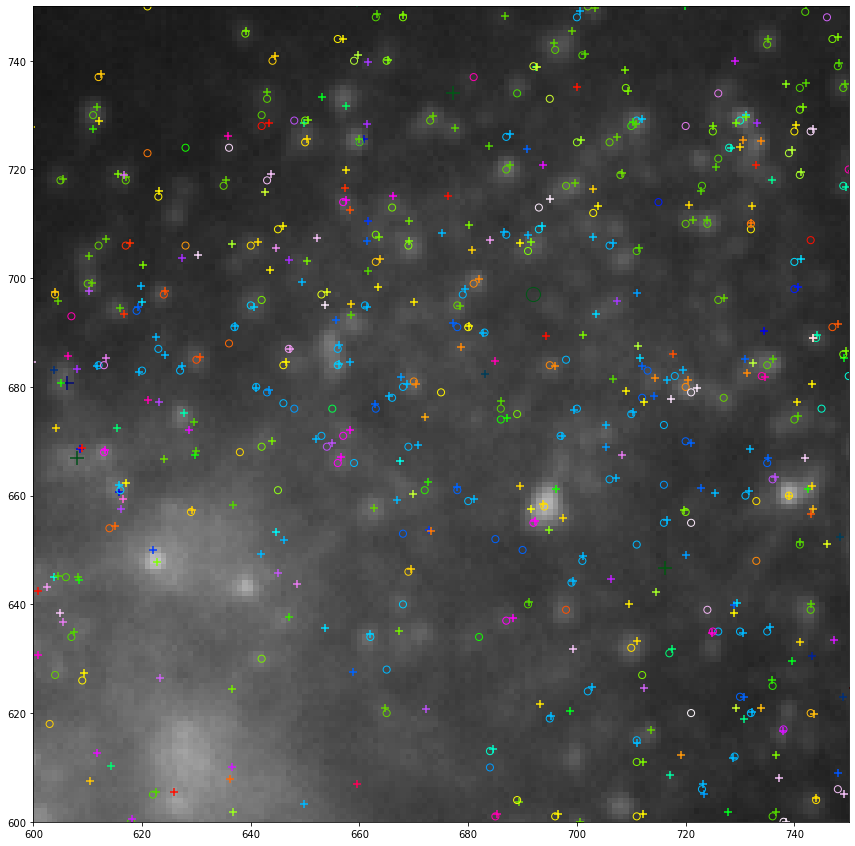

In [63]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_single)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(ist_sub)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

In [409]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5, size_z=10):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,int(z):int(z+1), int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

# Analyze blanks

26


,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,...,int_1,int_2,int_3,int_sig_0,int_sig_1,int_sig_2,int_sig_3,zm,int_tot,int_sig_tot
28421,28421,0,243,383.26723,68.88303,2.376363,0.658758,17.744606,23.340118,8.481233,...,5.209935,6.694495,8.023641,1.996939,1.568243,3.390814,3.319344,37.63626,26.435554,10.275341


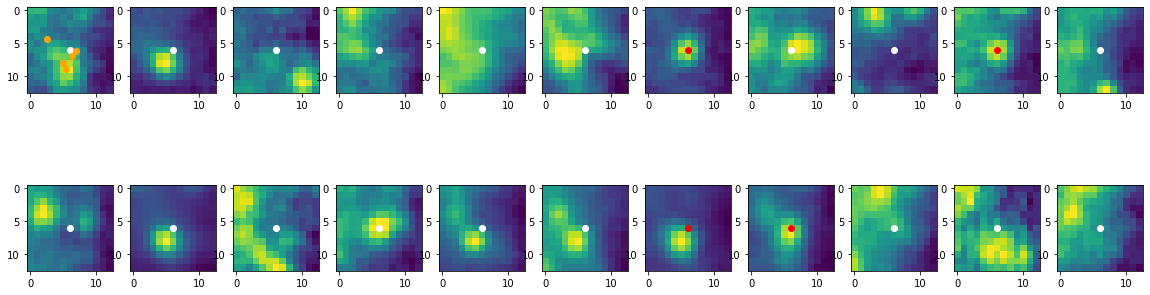

In [422]:
# Random predictions 
res_sub = res_df.nsmallest(20000, 'comb_sig')
# Random blank 
sub = res_sub[res_sub['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
bench_crop = crop_df(nm_to_px(bench_df), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
#     plt.title(str(np.round(b_loc[f'int_{i}'], 3)) + ' +- ' + str(np.round(b_loc[f'int_sig_{i}'], 3)))
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(bench_crop['x'],bench_crop['y'],color='purple', marker='+')

In [677]:
fn_inds = fns['loc_idx'].values

In [678]:
len(res_df)

15020

In [679]:
res_sub = res_df.nsmallest(10000, 'comb_sig')

,loc_idx,x,y,z,gene,frame_idx,code_inds
5894569,5894569,90.023502,729.022581,2.304147,Pdgfc,0,152


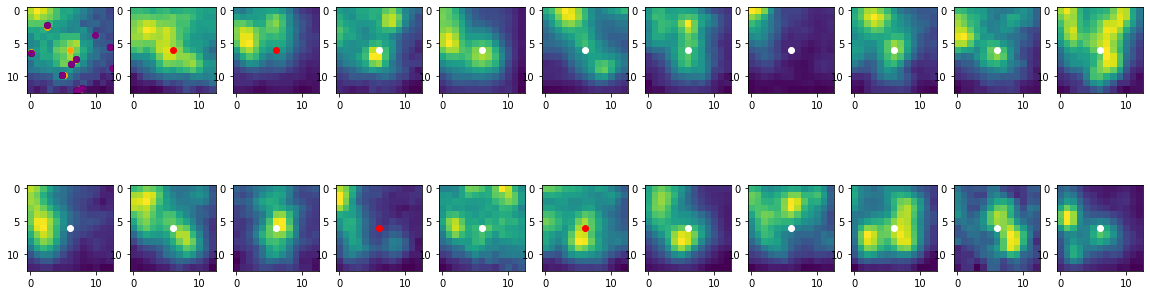

In [681]:
ind = np.random.randint(0, len(fn_inds))
ind = fn_inds[ind]

b_loc = nm_to_px(bench_df[bench_df['loc_idx'] == ind], px_size_zyx=[120.0, 100.0, 100.0]).iloc[0]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

cropb = crop_df(nm_to_px(bench_df, px_size_zyx=[120.0, 100.0, 100.0]), crop)
cropr = crop_df(nm_to_px(res_sub), crop)
cropf = crop_df(nm_to_px(res_df), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
    if not i:
        plt.scatter(cropb['x'],cropb['y'],color='orange')
        plt.scatter(cropr['x'],cropr['y'],color='black')
        plt.scatter(cropf['x'],cropf['y'],color='purple')

In [545]:
cropb

,loc_idx,x,y,z,gene,frame_idx,code_inds
5911774,5911774,6.497235,6.030876,0.760369,Olfm3,0,144


In [382]:
res_df = remove_doublets(df_dict['dec_num_iters:100000xenabled:False'])

In [383]:
keys = ['x_sig','y_sig','z_sig','prob','int_0', 'int_1', 'int_2', 'int_3', 'int_sig_0', 'int_sig_1', 'int_sig_2', 'int_sig_3', 'zm']
res_df['class'] = res_df['gene'].str.contains('Blank')*1

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [384]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

X = np.concatenate([res_df.nsmallest(10000,'comb_sig')[keys].values, res_df[res_df['class'] == 1][keys].values])
y = np.concatenate([res_df.nsmallest(10000,'comb_sig')['class'].values, res_df[res_df['class'] == 1]['class'].values])
 
clf = LogisticRegression(random_state=0,max_iter=10000).fit(X, y)

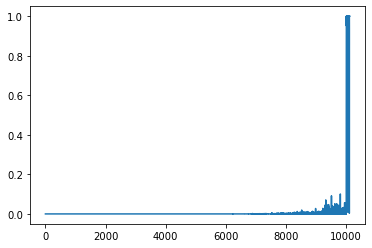

In [385]:
plt.plot(clf.predict_proba(X)[:,1])

In [386]:
# res_df = remove_doublets(df_dict['dec_num_iters:100000xenabled:False'])
res_df = remove_doublets(df_dict['dec_start_mic:30000xpsf_vol:Truextheta_par:Truexlr:0.0004'])
X = res_df[keys]

In [387]:
res_df['score'] = clf.predict_proba(X)[:,1]

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



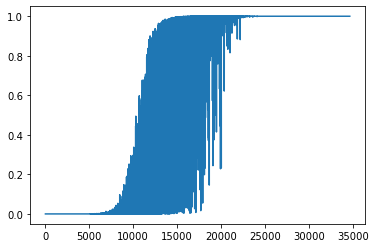

In [388]:
plt.plot(res_df.nsmallest(50000, 'comb_sig')['score'].values)

In [821]:
par_dict = {}

par_dict['comb_sig'] = [res_df, 'comb_sig', True]
par_dict['score'] = [res_df, 'score', True]

In [822]:
roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=50000)
    roc_dict[k] = [x, y]

In [823]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict[df.keys()[0]][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [824]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,100], range_x=[0,50000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

In [750]:
df_dict['47'].keys()

dict_keys(['_norm:nonexz_sig_fac:1.0', '_schedule:nullxfreq:1xnorm:escort', '_schedule:nullxfreq:3xnorm:none', '_norm:escortxz_sig_fac:1.0', '_schedule:nullxfreq:1xnorm:none', '_norm:nonexz_facs:True', '_norm:escortxz_facs:True', '_schedule:nullxfreq:3xnorm:escort'])

In [751]:
res_df1 = df_dict['47']['_norm:escortxz_sig_fac:1.0']
res_df2 = df_dict['47']['_norm:escortxz_facs:True']

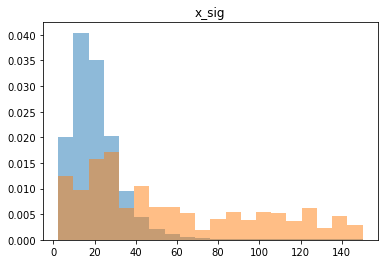

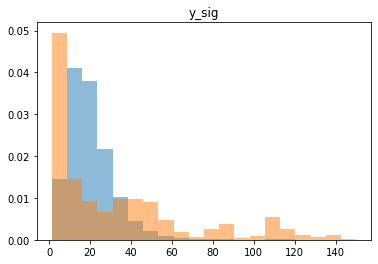

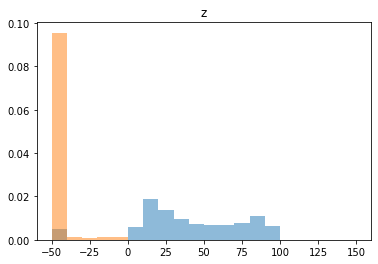

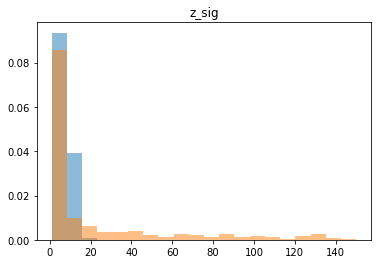

In [762]:
# for k in res_df1.keys():
for k in ['x_sig', 'y_sig', 'z', 'z_sig']:
    bins = np.linspace(res_df1[k].min(), 150, 21)
    plt.hist(sel_int_ch(res_df1, code_ref)[k], alpha=0.5, bins=bins, density=True)
    plt.hist(sel_int_ch(res_df1[res_df1['z'] < 0], code_ref)[k], alpha=0.5, bins=bins, density=True)
    plt.title(k)
    plt.show()